# LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import pyvisa as visa
import nidaqmx
from nidaqmx.constants import AcquisitionType
import time
import numpy as np
import sys
import os
import qontrol
import functions as func
import pickle as pkl
import scipy.signal

# CONSTANTS

In [2]:
F_MAX_NIDAQ = 500000 # Hz
F_DAC = 500 # Hz
T_DAC = 1 / F_DAC
N_CHANNEL = 10 # Number of channel
F_CHANNEL =  F_MAX_NIDAQ/N_CHANNEL # Frequency per channel that is used
V_PI_PM = 8 # Voltage for PI phase shift; see the specs of the phase modulator

<style>
    /* Apply CSS to the heading to expand the background */
    h1 {
        background-color: white;
        padding: 10px;
        display: block; /* Make the heading a block-level element */
        width: 100%; /* Expand the width to 100% */
        text-align: center; /* Center the text horizontally */
        vertical-align: middle; /* Center the text vertically */
    }
</style>

# <font color='black'>INSTRUMENTS.</font>


<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## AWG.


#### Connect to AWG

In [3]:
"""
Connection to the AWG
"""
rm=visa.ResourceManager()
li=rm.list_resources()
for index in range(len(li)):
    print(str(index)+" - "+li[index])
# choice = input("Which device?: ")
choice = 0
vi=rm.open_resource(li[int(choice)])

0 - USB0::0xF4EC::0xEE38::516L19115::INSTR
1 - ASRL1::INSTR
2 - ASRL3::INSTR
3 - ASRL4::INSTR


#### ID quiery

In [4]:
"""
Print the information of the device.
"""
print(vi.query("*idn?"))

BK,4055B,516L19115,1.01.01.33R1B3



#### Configure output

In [5]:
"""
We configure the device's channel as being a DC waveform.
"""
print("Configuring C1")
vi.write("c2:bswv wvtp,dc")
vi.write("c2:output on")
print(vi.query("c2:bswv?"))

Configuring C1


C2:BSWV WVTP,DC,OFST,3.5V



#### Send the commands

In [6]:
"""
Now the device's channel is set to DC voltage and that can be changed with the following command line.
We set the voltage to 0V.
"""
vi.write("c2:bswv ofst,3.5")
print(vi.query("c2:bswv?"))

C2:BSWV WVTP,DC,OFST,3.5V



<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## NIDAQ.


### <span style="background-color: white; padding: 10px;"><font color='black'>FFT.</font></span>


Freq is : 5641.349683184643
[[0.0004922222269048071, 0.0004915614373698081, 0.0004915614373698081, 0.0004915614373698081, 0.0004922222269048071, 0.0004928830164399715, 0.0004915614373698081, 0.0004922222269048071, 0.0004922222269048071, 0.0004928830164399715, 0.0004922222269048071, 0.0004928830164399715, 0.0004922222269048071, 0.0004922222269048071, 0.0004915614373698081, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.0004915614373698081, 0.0004928830164399715, 0.0004928830164399715, 0.0004922222269048071, 0.0004915614373698081, 0.0004922222269048071, 0.0004915614373698081, 0.0004915614373698081, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.0004928830164399715, 0.0004922222269048071, 0.0004909006478349746, 0.0004915614373698081, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.0004928830164399715, 0.0004922222269048071, 0.0004922222269048071, 0.0004922222269048071, 0.00

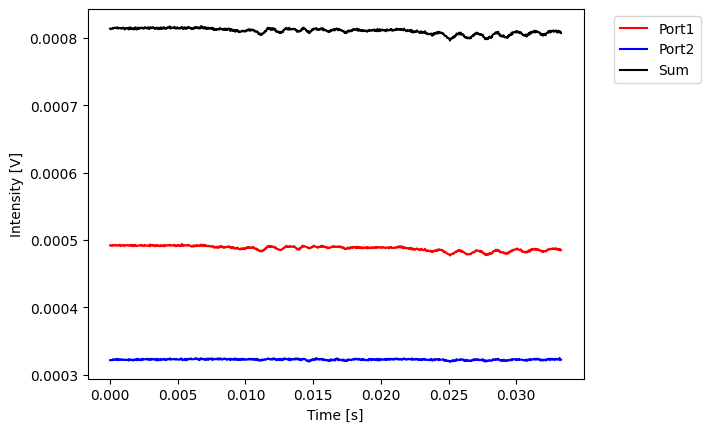

0.0004877222501772786


In [7]:
"""
Collect the voltage of two channels 16 and 17 here for a given set of parameter for the data acquisition
Then we plot the voltage vs time
"""
DATA = [[] for i in range(2)]
SamplingRate = 30000
Sample = 1000
for i in range(1):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_current_chan("Dev1/ai16")
        task.ai_channels.add_ai_current_chan("Dev1/ai17")
        task.timing.cfg_samp_clk_timing(rate = SamplingRate)
        start_time = time.time()
        voltage_data =task.read(number_of_samples_per_channel=Sample)
        end_time = time.time()
        frequence = Sample/(end_time-start_time)
        print("Freq is :",frequence)
        print(voltage_data)

# Create lists
SUM = [i+j for i,j in zip(voltage_data[0],voltage_data[1])]
TIME = [i/SamplingRate for i in range(Sample)]

# Plotting the measurements
plt.plot(TIME,voltage_data[0],color ="red",label = "Port1")
plt.plot(TIME,voltage_data[1],color ="blue",label = "Port2")
plt.plot(TIME,SUM,color="black",label = "Sum")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1)
plt.xlabel("Time [s]")
plt.ylabel("Intensity [V]")
plt.show()
print(np.mean(voltage_data[0]))


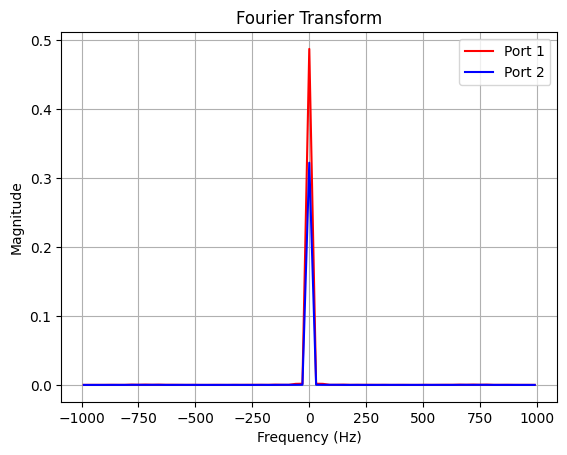

In [8]:
"""
Here the function gets the FFT of the previous data
"""

def plot_fourier_transform(DATA, sample_rate):
    colors = ["red", "blue"]
    index = 0
    for data in DATA:
        # Compute the Fast Fourier Transform (FFT) of the data
        fft_result = np.fft.fft(data)
        
        # Calculate the frequency values corresponding to the FFT result
        frequencies = np.fft.fftfreq(len(data), d=1/sample_rate)
        
        # Take the absolute value to get the magnitude (amplitude) of the complex values
        magnitude = np.abs(fft_result)
        
        # Filter frequencies and magnitudes to include only the range from -2500 to 2500
        filtered_indices = np.where((frequencies >= -1000) & (frequencies <= 1000))
        filtered_frequencies = frequencies[filtered_indices]
        filtered_magnitude = magnitude[filtered_indices]
        
        # Sort the frequencies and magnitudes based on frequencies
        sorted_indices = np.argsort(filtered_frequencies)
        sorted_frequencies = filtered_frequencies[sorted_indices]
        sorted_magnitude = filtered_magnitude[sorted_indices]

        # Plot the Fourier Transform
        plt.plot(sorted_frequencies, sorted_magnitude, color=colors[index], label="Port {}".format(index + 1))
        index += 1
    
    # Plot parameters
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function for the previous data
plot_fourier_transform(voltage_data,SamplingRate)


Freq is : 12378.676221029238
[[0.12042435877771676, 0.120095285590398, 0.120095285590398, 0.120095285590398, 0.12058889537143774, 0.12058889537143774, 0.12058889537143774, 0.12042435877771676, 0.12058889537143774, 0.12025982218403686, 0.12042435877771676, 0.12075343196519978, 0.12058889537143774, 0.12042435877771676, 0.12042435877771676, 0.12042435877771676, 0.12042435877771676, 0.12025982218403686, 0.120095285590398, 0.120095285590398, 0.12025982218403686, 0.11993074899680019, 0.120095285590398, 0.11993074899680019, 0.11993074899680019, 0.1197662124032434, 0.1197662124032434, 0.11960167580972761, 0.1197662124032434, 0.11943713921625282, 0.11960167580972761, 0.11943713921625282, 0.1197662124032434, 0.11993074899680019, 0.1197662124032434, 0.1197662124032434, 0.11960167580972761, 0.11960167580972761, 0.1197662124032434, 0.1197662124032434, 0.120095285590398, 0.1197662124032434, 0.120095285590398, 0.11993074899680019, 0.11993074899680019, 0.1197662124032434, 0.11943713921625282, 0.119601

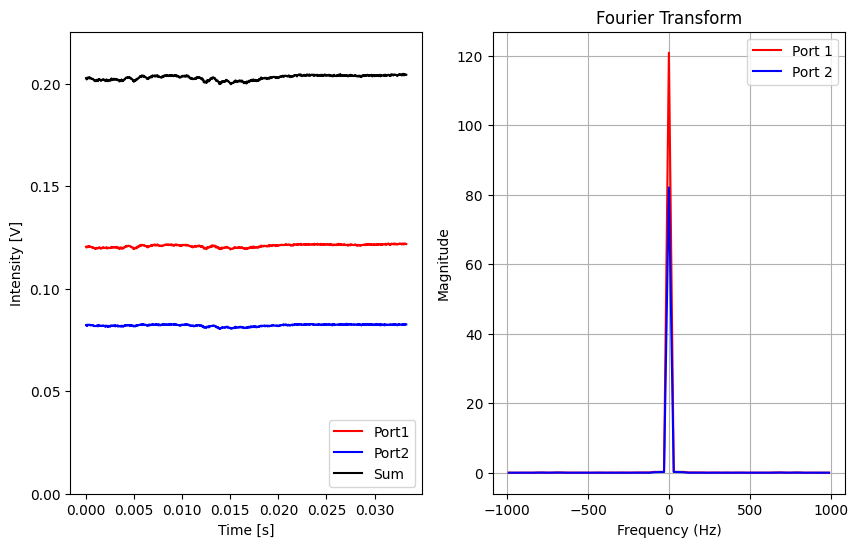

In [9]:
# 1. Generate Data from Experiment
DATA = [[] for i in range(2)]
SamplingRate = 30000
for i in range(1):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai16")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai17")
        task.timing.cfg_samp_clk_timing(rate = SamplingRate
            
        )
        sample = 1000
        start_time = time.time()
        voltage_data =task.read(number_of_samples_per_channel=sample)
        end_time = time.time()
        frequence = sample/(end_time-start_time)
        print("Freq is :",frequence)
        print(voltage_data)
#voltage_data = voltage_data[13700:14000]
SUM = [i+j for i,j in zip(voltage_data[0],voltage_data[1])]
TIME = [i/SamplingRate for i in range(sample)]

# 2. Plot waveform on left panel
(f, (ax1, ax2)) = plt.subplots(1, 2, figsize=(10,6))


ax1.plot(TIME,voltage_data[0],color ="red",label = "Port1")
ax1.plot(TIME,voltage_data[1],color ="blue",label = "Port2")
ax1.set_ylim(0, np.max(SUM)*1.1)
ax1.plot(TIME,SUM,color="black",label = "Sum")
ax1.legend(loc='lower right', ncol=1)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Intensity [V]")

# 3. Plot Fourier Transform in right panel
def plot_fourier_transform(DATA, sample_rate):
    colors = ["red", "blue"]
    index = 0
    for data in DATA:
        # Compute the Fast Fourier Transform (FFT) of the data
        fft_result = np.fft.fft(data)
        
        # Calculate the frequency values corresponding to the FFT result
        frequencies = np.fft.fftfreq(len(data), d=1/sample_rate)
        
        # Take the absolute value to get the magnitude (amplitude) of the complex values
        magnitude = np.abs(fft_result)
        
        # Filter frequencies and magnitudes to include only the range from -2500 to 2500
        filtered_indices = np.where((frequencies >= -1000) & (frequencies <= 1000))
        filtered_frequencies = frequencies[filtered_indices]
        filtered_magnitude = magnitude[filtered_indices]
        
        # Sort the frequencies and magnitudes based on frequencies
        sorted_indices = np.argsort(filtered_frequencies)
        sorted_frequencies = filtered_frequencies[sorted_indices]
        sorted_magnitude = filtered_magnitude[sorted_indices]

        # Plot the Fourier Transform
        ax2.plot(sorted_frequencies, sorted_magnitude, color=colors[index], label="Port {}".format(index + 1))
        index += 1
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Fourier Transform')
    ax2.grid(True)
    ax2.legend()
    
plot_fourier_transform(voltage_data,SamplingRate)
plt.show()

### <span style="background-color: white; padding: 10px;"><font color='black'>Some functions.</font></span>


#### Channel arrange

In [10]:
def channels_arrangement(nums):
    if not nums:
        return
    
    result = []
    current_range = [nums[0]]
    channels_arranged = []

    for i in range(1, len(nums)):
        if nums[i] == nums[i - 1] + 1:
            current_range.append(nums[i])
        else:
            result.append(current_range)
            current_range = [nums[i]]

    result.append(current_range)

    for r in result:
        if len(r) == 1:
            channels_arranged.append(f"Dev1/ai{r[0]}")
        else:
            channels_arranged.append(f"Dev1/ai{r[0]}:{r[-1]}")
            
    return channels_arranged

#### Max Min

In [11]:
def maxmin(powers, voltage):
    '''
    Analyzes multiple power data sets with respect to voltage and returns the maximum and minimum values 
    of each data set in a nested list.
    
    Parameters:
    - powers: List of power data sets (e.g., [power1, power2,..., powerN])
    - voltage: The common voltage array for all power readings
    
    Returns:
    - List of [min, max] pairs for each power data set
    '''

    # List to store maximums and minimums
    max_values = []
    min_values = []
    
    # List to store x values corresponding to maximums and minimums
    x_max_values = []
    x_min_values = []
    
    colors = ["red", "blue", "green", "purple", "yellow", "cyan", "magenta", "orange", "pink", "brown"] # Add more colors if needed

    for idx, power in enumerate(powers):
        pnorm = scipy.signal.savgol_filter(power, 20, 6)
        
        # Find peaks (maxima)
        peaks, _ = scipy.signal.find_peaks(pnorm)
        
        # Find troughs (minima)
        troughs, _ = scipy.signal.find_peaks(-pnorm, prominence=-0.1)  # Use a negative prominence value

        max_power = [pnorm[p] for p in peaks]
        min_power = [pnorm[t] for t in troughs]
        
        # Corresponding X values for maxima and minima rounded to one decimal place
        x_max = [round(voltage[p], 1) for p in peaks]
        x_min = [round(voltage[t], 1) for t in troughs]

        # Plot the curve first
        plt.plot(voltage, pnorm, color=colors[idx % len(colors)], zorder=1)

        # Plot the maxima and minima points on top of the curve using zorder=2
        plt.scatter(x_max, max_power, color='black', label='Maxima' if idx == 0 else "", zorder=2)
        plt.scatter(x_min, min_power, color='grey', label='Minima' if idx == 0 else "", zorder=2)
            
        max_values.append(max_power)
        min_values.append(min_power)
        
        x_max_values.append(x_max)
        x_min_values.append(x_min)


    plt.legend()
    plt.show()

    return x_max_values, x_min_values

#### To Power

In [12]:
def to_power(V, I):
    """
    Calculate the power (in watts) using the formula P = V * I.
    
    Parameters:
    - V : 2D list of voltages. Outer dimension is the measurement index, and inner dimension is the channel index.
    - I : 2D list of currents. Same dimensions as V.
    
    Returns:
    - P_W_mean : 2D list of mean power values in watts. Same dimensions as V and I.
    """
    N_STEP = len(V)
    N_CHANNEL = len(V[0])
    P_W_mean = []

    for ch_index in range(N_CHANNEL):
        P_temp = []  # Create a new list for each channel
        for meas_index in range(N_STEP):
            P_temp.append(np.mean(np.multiply(V[meas_index][ch_index], I[meas_index][ch_index])))
        P_W_mean.append(P_temp)

    return P_W_mean


#### Power to dBm

In [13]:
def power_to_dBm(power_watts):
    """
    Convert power from Watts to dBm.
    :param power_watts: List or array of power values in Watts.
    :return: List or array of power values in dBm.
    """
    power_dBm = 10 * np.log10(np.array(power_watts) * 1000)  # Convert to milliwatts then take 10*log10
    return power_dBm

#### Save Data

In [14]:
"""
Save the data into a pkl file in the .data folder
TODO get the V,I,P,V_max, PS_Voltages, which device is tuned, and save
"""
P1,P2 = [],[]
# Define the two lists you want to save in the dictionary
Power1 = list(P1)
Power2 = list(P2)
Voltage = None

# Create a dictionary to hold the lists
data_dict = {
    "Power1": Power1,
    "Power2": Power2,
    "Voltage": None
}

# Define the path to the .data folder in the current directory
data_folder = ".data"

# Create the .data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Define the path to the pickle file within the .data folder
pickle_file_path = os.path.join(data_folder, "data.pkl")

# Save the dictionary to the pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pkl.dump(data_dict, pickle_file)

print(f"Data saved to {pickle_file_path}")


Data saved to .data\data.pkl


### <span style="background-color: white; padding: 10px;"><font color='black'>Measurement functions.</font></span>


#### Get voltage

In [15]:
def get_voltage(channels_list, sampling_rate, n_sample, AcqType):
    # Get voltages
    with nidaqmx.Task() as task:
        # Add channels
        for ch in channels_arrangement(channels_list):
            task.ai_channels.add_ai_voltage_chan(ch, min_val=0, max_val=0.5)

        # Configure the sampling
        task.timing.cfg_samp_clk_timing(rate=sampling_rate,
                                        sample_mode=AcqType,
                                        samps_per_chan=n_sample)

        # Read out the task
        voltage_data = task.read(number_of_samples_per_channel=n_sample)

        return voltage_data

#### Get current

In [16]:
def get_current(channels_list, sampling_rate, n_sample, AcqType):
    # Get currents
    with nidaqmx.Task() as task:
        # Add channels
        for ch in channels_arrangement(channels_list):
            task.ai_channels.add_ai_current_chan(ch, min_val=0, max_val=0.001)

        # Configure the sampling
        task.timing.cfg_samp_clk_timing(rate=sampling_rate,
                                        sample_mode=AcqType,
                                        samps_per_chan=n_sample)

        # Read out the task
        current_data = task.read(number_of_samples_per_channel=n_sample)

        return current_data


#### Get measurements

In [17]:
def get_measurements(channels_list, sampling_rate, n_sample):

    # Get voltages and current from channels1
    V = get_voltage(channels_list, sampling_rate, n_sample, AcquisitionType.CONTINUOUS)
    I = get_current(channels_list, sampling_rate, n_sample, AcquisitionType.CONTINUOUS)

    return (V, I)

<style>
    /* Apply CSS to the heading to expand the background */
    h2 {
        background-color: yellow;
        padding: 10px;
        width: 100%; /* Expand the width to 100% */
        color: black; /* Set the text color to blue */
    }
</style>

## Measurements.


### <span style="background-color: white; padding: 10px;"><font color='black'>Measurement constants.</font></span>


#### Sampling contants

In [18]:
sampling_rate = 50000
n_sample      = 500
N             = 10
channels_list = [0,1,2,3,4,5,6,7,16,17]

#### Bar and cross states

In [19]:
# [bar states, cross state]

LX11 = None
LX12 = None
LX21 = None
LX31 = None
LX32 = None
LX41 = [[4, 5.8],[2.75, 5.05, 6.55]]

L11 = None
L12 = None
L21 = None
L31 = None
L32 = None
L41 = [[4.2,5.8], [3.2, 5.2, 6.6]] # Light comes from top left # L41 = [[2.2, 4.5, 6.0] , [3.4, 5.3, 6.7]] # Light come from bottom left

MZM1 = [ [2.7, 5.0, 6.5] , [0.1, 1.0, 4.0, 5.8] ] # 0 and 1 states resp. 71
MZM2 = [ [0.4, 4.0, 5.7] , [2.9, 5.0, 6.6]      ] # 73
MZM3 = [ [0.4, 3.7, 5.5] , [2.0, 4.6, 6.2]      ] # 75
MZM4 = [ [0] , [0] ]

#### MZI dictionnaries

In [20]:
SX = [None] * 6
S  = [None] * 6

T_Names = ["T11","T12","T22","T31","T32","T41"]

mzi_X = {
    "T11": {"external": 32, "internal": 34, "mzi_type": "class1", "cross": LX11, "bar": LX11, "state": SX[0]},
    "T12": {"external": 31, "internal": 33, "mzi_type": "class1", "cross": LX12, "bar": LX12, "state": SX[1]},
    "T21": {"external": 36, "internal": 37, "mzi_type": "class1", "cross": LX21, "bar": LX12, "state": SX[2]},
    "T31": {"external": 39, "internal": 40, "mzi_type": "class1", "cross": LX31, "bar": LX32, "state": SX[3]},
    "T32": {"external": 43, "internal": 41, "mzi_type": "class2", "cross": LX11, "bar": LX12, "state": SX[4]},
    "T41": {"external": 46, "internal": 44, "mzi_type": "class2", "cross": LX11, "bar": LX12, "state": SX[5]}
}

mzi = {
    "T11" : {"external": 79, "internal": 81, "mzi_type": "class1", "cross": L11, "bar": L11, "state": S[0]},
    "T12" : {"external": 80, "internal": 84, "mzi_type": "class1", "cross": L12, "bar": L12, "state": S[1]},
    "T21" : {"external": 83, "internal": 85, "mzi_type": "class1", "cross": L21, "bar": L12, "state": S[2]},
    "T31" : {"external": 86, "internal": 86, "mzi_type": "class1", "cross": L31, "bar": L32, "state": S[3]},
    "T32" : {"external": 90, "internal": 91, "mzi_type": "class2", "cross": L11, "bar": L12, "state": S[4]},
    "T41" : {"external": 93, "internal": 94, "mzi_type": "class2", "cross": L11, "bar": L12, "state": S[5]},
    "MZM1": {"top"     : 71, "bottom"  : 72, "zero" : MZM1[0]    , "one"  : MZM1[1]},
    "MZM2": {"top"     : 73, "bottom"  : 74, "zero" : MZM2[0]    , "one"  : MZM2[1]},
    "MZM3": {"top"     : 75, "bottom"  : 76, "zero" : MZM3[0]    , "one"  : MZM3[1]},
    "MZM4": {"top"     : 77, "bottom"  : 78, "zero" : MZM4[0]    , "one"  : MZM4[1]}
}

### <span style="background-color: white; padding: 10px;"><font color='black'>Output channel powers.</font></span>


C:\Users\QPG\AppData\Local\Temp\ipykernel_25736\3980121268.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(P_dBm_mean, 'bo-', label="Power (Channels)", markersize=8, linestyle=None)


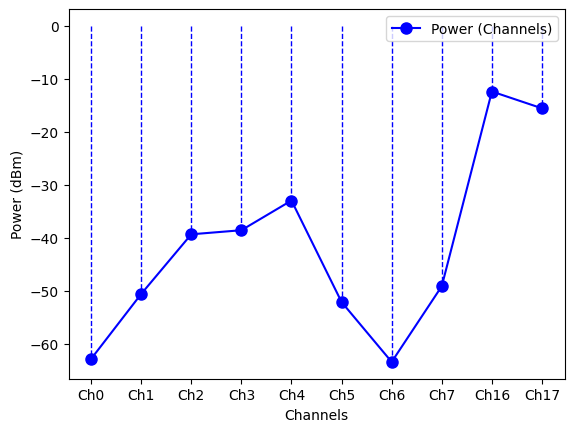

In [21]:
V_mean       = [None] * (N)
I_mean       = [None] * (N)
P_W_mean     = [None] * (N)
P_dBm_mean   = [None] * (N)


V, I = get_measurements(channels_list, sampling_rate, n_sample)

for ch_index in range(len(V)):
    V_mean[ch_index]     = np.mean(V[ch_index])                      # mean voltage
    I_mean[ch_index]     = np.mean(I[ch_index])                      # mean current
    P_W_mean[ch_index]   = V_mean[ch_index] * I_mean[ch_index]       # W
    P_dBm_mean[ch_index] = 10 * np.log10(P_W_mean[ch_index] / 0.001) # dBm


# Create a list of channel labels
channel_labels = [f'Ch{i}' for i in range(len(V)-2)]
channel_labels.extend(['Ch16', 'Ch17'])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data points for Channels1 as blue markers with channel labels on the x-axis
ax.plot(P_dBm_mean, 'bo-', label="Power (Channels)", markersize=8, linestyle=None)

# Set the x-axis ticks to match the number of labels
ax.set_xticks(range(len(channel_labels)))

# Set the x-axis labels
ax.set_xticklabels(channel_labels)

# Draw vertical lines connecting the data points to the X-axis
for x, y in enumerate(P_dBm_mean):
    ax.vlines(x, 0, y, colors='b', linestyles='dashed', linewidth=1)

# Set labels and legend
ax.set_xlabel("Channels")
ax.set_ylabel("Power (dBm)")
ax.legend()
plt.show()




### <span style="background-color: white; padding: 10px;"><font color='black'>Individual measurements.</font></span>


In [22]:
def sweep_collect_ports(phase_shifter_port, channels_list, v_max, phase_shifter_set = None):
    """
    sweep_collect_ports : this function acquire the voltage and current of the specified output 
    ports of the NiDAQ.
    phase_shifter_ports : this represent the number associated with the phase shifter to be tuned.
    This usually comes with the pinout of your PCB/Chip.
    channels_list : this represent a list of integer that are related to the NIDAQ output that has
    to be read out. For exemple if the list is [1, 2, 6], then the channels to be added to the Nidaq
    Task would be "Dev1/ai1:2" and "Dev1/ai6". This is taken care in get_measurements
    v_max : is the constant defining what is the max voltage to be tuned to.
    phase_shifter_set : represents a list of phase shifter that are representing some MZI are a ceratin
    state such as bar or cross state. If this list is None, then all MZI have a random phase shift 
    """
    
    # Connected to COM3
    serial_port_name = "COM3"
    # Setup Qontroller
    q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)
    # Initialize all ports to 0
    q.v[:]  = 0
    # q.v[91] = 4.3 # light to bottom
    # q.v[91] = 3.1 # light to top
    # q.v[88] = 3.7 # light to top
    # q.v[81] = 5.9 # light get's low at output 1

    if phase_shifter_set != None :
        # Set the phase shifters if needed
        for state_index, state in enumerate(phase_shifter_set):
            if   state==0:
                q.v[mzi[T_Names[state_index]]["external"]] = mzi[T_Names[state_index]]["cross"][0]
            elif state==1:
                q.v[mzi[T_Names[state_index]]["external"]] = mzi[T_Names[state_index]]["bar"][0]
            else:
                pass

    # Sweeping parameters
    v_step  = 0.1
    N_STEP  = int(v_max / v_step)

    # Sampling parameters
    sampling_rate = 50000
    n_sample      = 500

    # Initiate the lists
    V            = [None] * (N_STEP)
    I            = [None] * (N_STEP)

    # Sweeping and data acquisition
    for step in range(N_STEP):
        
        # Settings
        set_voltage  = step*v_step
        q.v[phase_shifter_port] = set_voltage

        # Thermal Phase Shifter frequency maybe to be removed
        time.sleep(1/5000)
        
        # Returns the Vs and Is channels [1] and [2] - Raw values
        V[step], I[step] = get_measurements(channels_list, sampling_rate, n_sample)
    
    print(f"The voltage is {q.v[phase_shifter_port]} V")

    q.v[:] = 0
    q.close()
    print("Sweep complete.")

    # TO DO : Measure all the qontrol DAC voltages of every channels after the sweep and return the list to save into a pkl file
    return (V,I)

Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8672 V
Sweep complete.


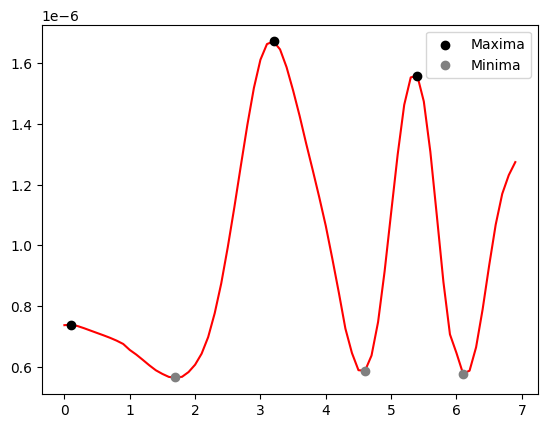

Results for 30 is :  ([[0.1, 3.2, 5.4]], [[1.7, 4.6, 6.1]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8923 V
Sweep complete.


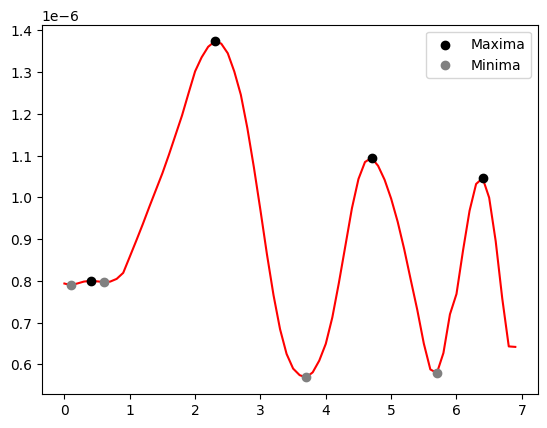

Results for 29 is :  ([[0.4, 2.3, 4.7, 6.4]], [[0.1, 0.6, 3.7, 5.7]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8742 V
Sweep complete.


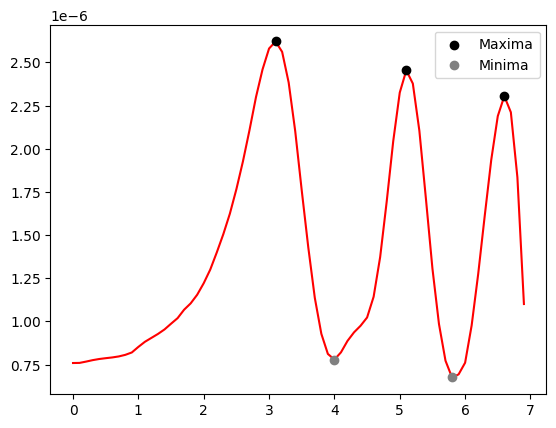

Results for 28 is :  ([[3.1, 5.1, 6.6]], [[4.0, 5.8]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8823 V
Sweep complete.


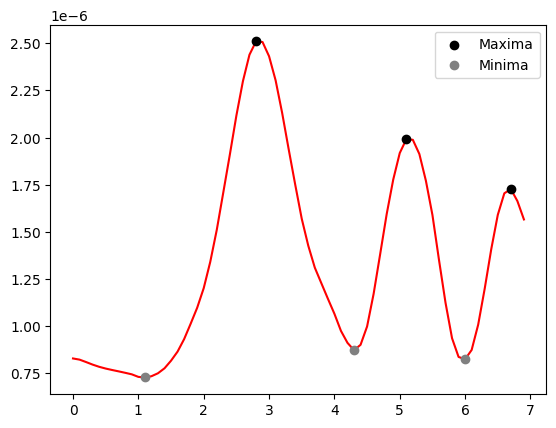

Results for 27 is :  ([[2.8, 5.1, 6.7]], [[1.1, 4.3, 6.0]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8973 V
Sweep complete.


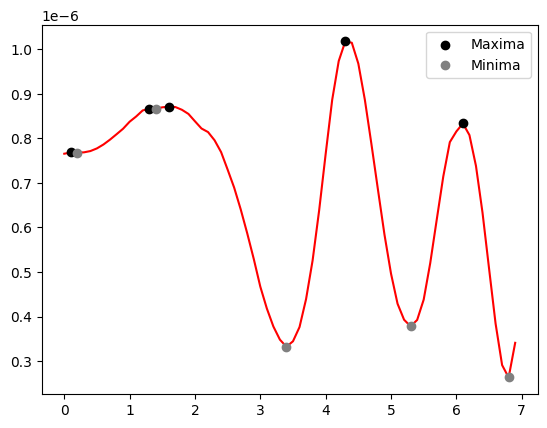

Results for 26 is :  ([[0.1, 1.3, 1.6, 4.3, 6.1]], [[0.2, 1.4, 3.4, 5.3, 6.8]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 0.0723 V
Sweep complete.


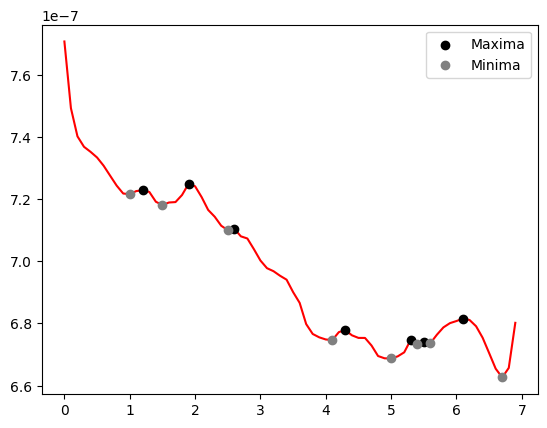

Results for 25 is :  ([[1.2, 1.9, 2.6, 4.3, 5.3, 5.5, 6.1]], [[1.0, 1.5, 2.5, 4.1, 5.0, 5.4, 5.6, 6.7]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 0.0718 V
Sweep complete.


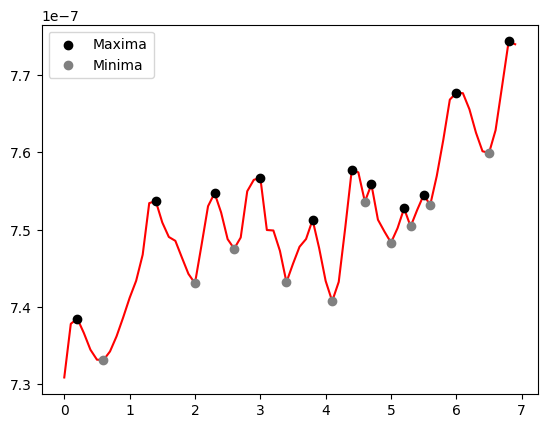

Results for 24 is :  ([[0.2, 1.4, 2.3, 3.0, 3.8, 4.4, 4.7, 5.2, 5.5, 6.0, 6.8]], [[0.6, 2.0, 2.6, 3.4, 4.1, 4.6, 5.0, 5.3, 5.6, 6.5]])
Driver thresholds set @ 12 V , 20 mA
The voltage is 0.0259 V
Sweep complete.


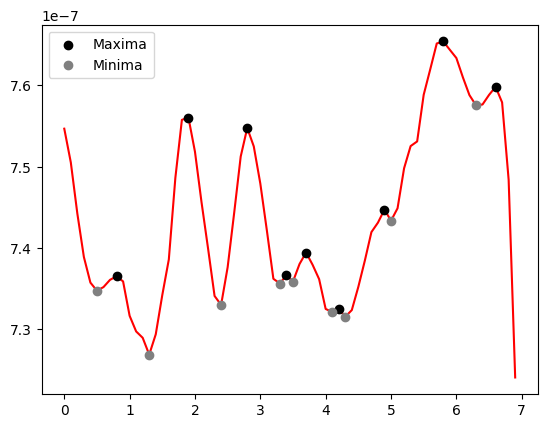

Results for 23 is :  ([[0.8, 1.9, 2.8, 3.4, 3.7, 4.2, 4.9, 5.8, 6.6]], [[0.5, 1.3, 2.4, 3.3, 3.5, 4.1, 4.3, 5.0, 6.3]])


In [33]:
phase_shifter_port  = 78
phase_shifter_ports_X = [71,72,73,74,75,76,77,78]
phase_shifter_ports   = [30,29,28,27,26,25,24,23]
channels_list = [0,1,2,3,4,5,6,7,16,17]
v_max = 7

for phase_shifter_port in phase_shifter_ports:
    Data = sweep_collect_ports(phase_shifter_port, channels_list, v_max)
    V    = Data[0]
    I    = Data[1]
    P    = to_power(V, I)
    voltage = np.arange(0,7,0.1)
    sum_power_0_to_8 = np.sum(P[:8], axis=0)
    print(f"Results for {phase_shifter_port} is : ",maxmin([sum_power_0_to_8],voltage))
       

In [24]:
phase_shifter_port  = 30
channels_list = [0,1,2,3,4,5,6,7,16,17]
v_max = 7

Data = sweep_collect_ports(phase_shifter_port, channels_list, v_max)


Driver thresholds set @ 12 V , 20 mA
The voltage is 6.8675 V
Sweep complete.


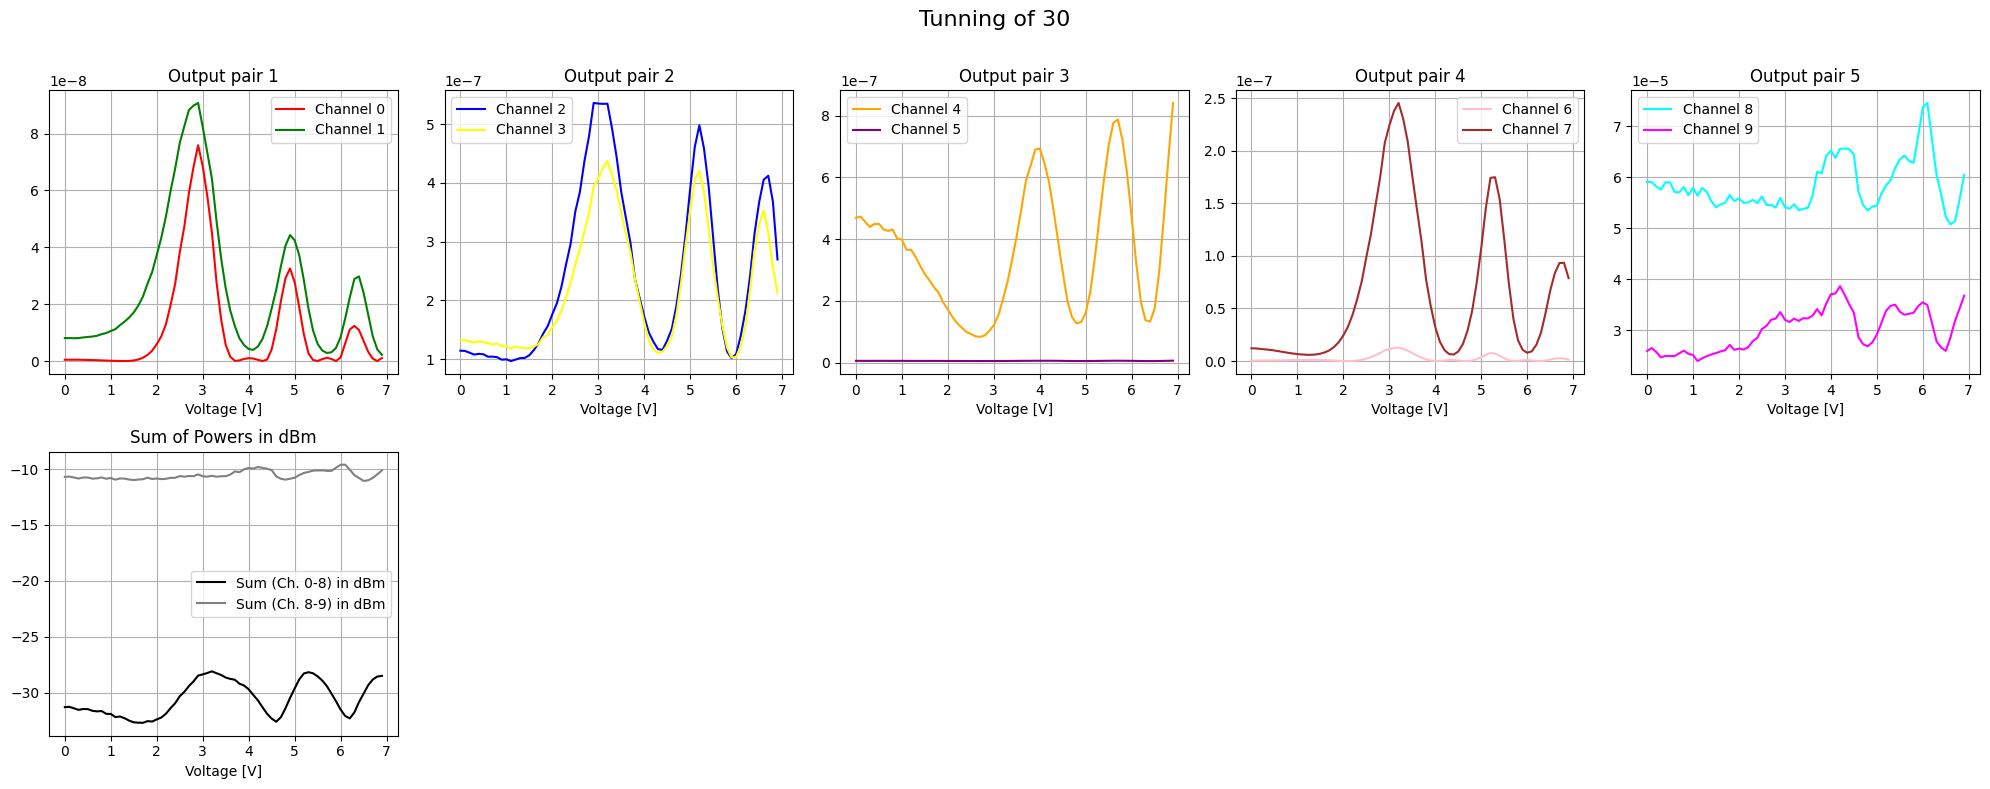

In [32]:
V = Data[0]
I = Data[1]
P = to_power(V, I)
voltage = np.arange(0, 7, 0.1)
colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "cyan", "magenta"]

# Calculate the number of sub-plots needed (5 pairs)
num_pairs = len(P) // 2

# Create a figure with 2 rows of subplots: The first row has 5 plots, the second row has 1 plot (for summed powers)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Set X label for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel("Voltage [V]")

fig.suptitle("Tunning of {}".format(phase_shifter_port), fontsize=16)
for i in range(num_pairs):
    pair = [i * 2, i * 2 + 1]  # Indices of the pair (e.g., [0, 1], [2, 3], ...)
    ax = axes[0, i]

    for channel_index in pair:
        P[channel_index] = np.array(P[channel_index])
        
        # Check for negative values and adjust accordingly
        min_val = P[channel_index].min()
        if min_val < 0:
            P[channel_index] += abs(min_val)
            print("Added power for positive : {}".format(abs(min_val)))

        ax.plot(voltage, P[channel_index], color=colors[channel_index], label=f"Channel {channel_index}")
        ax.set_title(f"Output pair {i + 1}")
        ax.grid(True)

        ax.legend()

# Plotting the sum of powers for channels 0 to 7 and channels 8, 9 in dBm in the second row
sum_power_0_to_8 = np.sum(P[0:8], axis=0)
sum_power_8_9 = np.sum(P[8:], axis=0)

sum_power_0_to_8_dBm = power_to_dBm(sum_power_0_to_8)
sum_power_8_9_dBm = power_to_dBm(sum_power_8_9)

axes[1, 0].plot(voltage, sum_power_0_to_8_dBm, color="black", label="Sum (Ch. 0-8) in dBm")
axes[1, 0].plot(voltage, sum_power_8_9_dBm, color="gray", label="Sum (Ch. 8-9) in dBm")
axes[1, 0].set_title("Sum of Powers in dBm")
axes[1, 0].grid(True)
axes[1, 0].legend()

# Remove the unused subplots in the second row
for i in range(1, 5):
    fig.delaxes(axes[1, i])

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjusting the main title space
plt.show()


In [26]:
print(mzi['MZM3']['zero'])

[0.4, 3.7, 5.5]


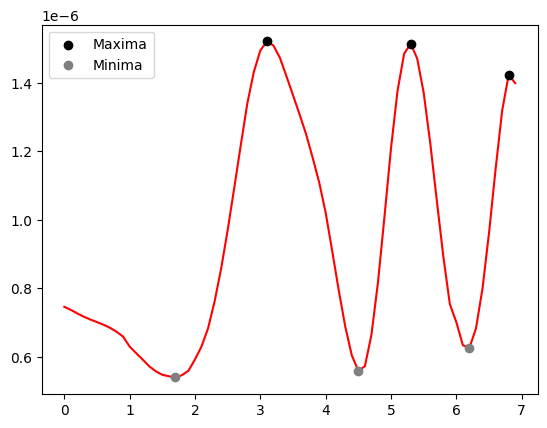

([[3.1, 5.3, 6.8]], [[1.7, 4.5, 6.2]])

In [27]:
voltage = np.arange(0,7,0.1)
maxmin([sum_power_0_to_8],voltage)

In [28]:
print(len(Data))          # Data V and I
print(len(Data[0]))       # Data V
print(len(Data[0][0]))    # Data V of one measurement @__Volt of all channel
print(len(Data[0][0][0])) # Data V of one measurement @__Volt corresponding at k channel

2
70
10
500


In [29]:
def mzi1_unitary(theta, phi, alpha, beta):
    """
    This represents the theoretical function of an MZI with two beam splitters
    and two phase shifters
    ---Phi--\       /--Theta--\      /----
    .        =alpha=           =beta=
    --------/       \---------/      \----
    """
    a = np.exp( 1j*phi )*( np.cos( alpha - beta )*np.sin( theta/2 ) + 1j*np.sin(alpha + beta)*np.cos( theta/2 ) )
    b =                    np.cos( alpha + beta )*np.cos( theta/2 ) + 1j*np.sin(alpha - beta)*np.sin( theta/2 )
    c = np.exp( 1j*phi )*( np.cos( alpha + beta )*np.cos( theta/2 ) - 1j*np.sin(alpha - beta)*np.sin( theta/2 ) )
    d =                  - np.cos( alpha - beta )*np.sin( theta/2 ) + 1j*np.sin(alpha + beta)*np.cos( theta/2 )
    return 1j*np.exp(1j*theta/2)*(np.array([[a, b], [c, d]]))

In [30]:
len(P[0] / P[0].max())

70

Fitted values: alpha=0.19172552329875203, beta=0.0574752378208195, phi=2.3847611271845386, m=0.9782020877531855, n=0.3498982668936509


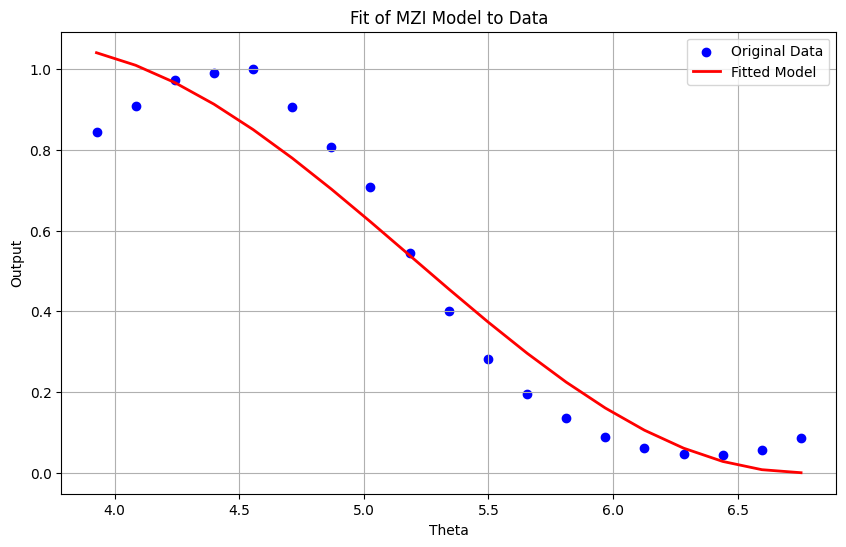

In [31]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def mzi1_unitary(theta, alpha, beta, phi, m, n):
    # Ensure theta is an array
    theta = np.array(theta, ndmin=1)
    
    # Compute output for each theta value
    outputs = []
    for t in theta:
        matrix = np.array([
            [np.exp(1j*phi) * (np.cos(alpha - beta)*np.sin(t/2) + 1j*np.sin(alpha + beta)*np.cos(t/2)),
             np.cos(alpha + beta)*np.cos(t/2) + 1j*np.sin(alpha - beta)*np.sin(t/2)],
            [np.exp(1j*phi) * (np.cos(alpha + beta)*np.cos(t/2) - 1j*np.sin(alpha - beta)*np.sin(t/2)),
            -np.cos(alpha - beta)*np.sin(t/2) + 1j*np.sin(alpha + beta)*np.cos(t/2)]
        ])
        output_vector = np.dot(matrix, [m, n])
        outputs.append(np.abs(output_vector[0])**2)
    
    return np.array(outputs)


def fit_mzi(data_theta, data_output):
    def fit_func(theta, alpha, beta, phi, m, n):
        return mzi1_unitary(theta, alpha, beta, phi, m, n)
    
    initial_guess = [0.12425317356874421, 
                     0.16332494800247105, 
                     5, 
                     0.43086450156078004, 
                     0.7407565483054235]
    
    # Set bounds for the parameters
    # (lower bounds), (upper bounds)
    param_bounds = ([0, 0, -np.inf, 0, 0], 
                    [0.2, 0.2, np.inf, 1, 1])
    
    popt, _ = curve_fit(fit_func, data_theta, data_output, p0=initial_guess, bounds=param_bounds)
    return popt  # <--- Added this line

    

# Example usage:
data_theta = np.arange(0, 7, 0.1)
data_theta = (np.pi / 2) * data_theta[25:44]
data_output = P[1] / P[1].max()
data_output = data_output[25:44]

fitted_params = fit_mzi(data_theta, data_output)
print(f"Fitted values: alpha={fitted_params[0]}, beta={fitted_params[1]}, phi={fitted_params[2]}, m={fitted_params[3]}, n={fitted_params[4]}")

# Plot the original data and the fitted model
plt.figure(figsize=(10,6))
plt.scatter(data_theta, data_output, label='Original Data', color='blue')
plt.plot(data_theta, mzi1_unitary(data_theta, *fitted_params), label='Fitted Model', color='red', linewidth=2)
plt.xlabel('Theta')
plt.ylabel('Output')
plt.title('Fit of MZI Model to Data')
plt.legend()
plt.grid(True)
plt.show()
